In [1]:
import math
import torch
from pykeops.torch import LazyTensor
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# from ..src.data_utils import load_data

In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))
from src.data_utils import load_data

In [3]:
def rbf(sigma, device, X1, X2=None):
    x1_lazy = LazyTensor(X1[:, None, :])
    if X2 is None:
        x2_lazy = LazyTensor(X1[None, :, :])
    else:
        x2_lazy = LazyTensor(X2[None, :, :])

    D = ((x1_lazy - x2_lazy) ** 2).sum(dim=2)
    K = (-D / (2 * sigma ** 2)).exp()

    identity_shape = X1.shape[0] if X2 is None else X2.shape[0]
    return K @ torch.eye(identity_shape, device=device)

def l1_laplace(sigma, device, X1, X2=None):
    x1_lazy = LazyTensor(X1[:, None, :])
    if X2 is None:
        x2_lazy = LazyTensor(X1[None, :, :])
    else:
        x2_lazy = LazyTensor(X2[None, :, :])

    D = ((x1_lazy - x2_lazy) ** 2).sum(dim=2)
    K = (-D / sigma).exp()

    identity_shape = X1.shape[0] if X2 is None else X2.shape[0]
    return K @ torch.eye(identity_shape, device=device)

In [4]:
torch.manual_seed(0)

In [5]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [6]:
sigma = 5120.
# delta = 0.01
lambd = 1e-3
n_components = 4000

# Load data and standardize
# X, y = load_svmlight_file("../data/cod-rna")
X, y, _, _ = load_data("homo", seed=0, device=device)
# Get 10000 random samples
X = X[torch.randperm(X.shape[0])[:10000]]
# X = X.toarray()
# # X = X[:5000, :] # Subsample
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# X = torch.tensor(X, device=device, dtype=torch.float32)

def kernel_fn_rbf(Y1, Y2=None):
    return rbf(sigma, device, Y1, Y2)


def kernel_fn_l1_laplace(Y1, Y2=None):
    return l1_laplace(sigma, device, Y1, Y2)

### Alg. 2 from "Recursive Sampling for the Nyström Method" by Musco & Musco (2017)

In [7]:
# def rrls_nystrom2(X, kernel_fn, lambd, delta, device):
#     m, _ = X.shape
#     print(f"m ub = {192 * torch.log(1/delta)}")
#     if m <= 192 * torch.log(1 / delta):
#         return torch.eye(m, device=device)
    
#     # Sample rows of X independently, each with probability 1/2
#     S_bar = torch.bernoulli(0.5 * torch.ones(m, device=device)).bool()
#     S_bar_mat = torch.zeros(m, torch.sum(S_bar), device=device)
#     S_bar_mat[S_bar, torch.arange(torch.sum(S_bar))] = 1
#     S_til = rrls_nystrom2(X[S_bar], kernel_fn, lambd, delta / 3, device)
#     print(f"S_bar_mat.shape = {S_bar_mat.shape}")
#     print(f"S_til.shape = {S_til.shape}")
#     S_hat = S_bar_mat @ S_til # TODO(pratik): Try making this more efficient in the future

#     # Compute approximate leverage scores
#     K = kernel_fn(X)
#     S_hatT_K = S_hat.T @ K
#     C = S_hatT_K @ S_hat # TODO(pratik): optimize this -- think of it as taking the block kernel followed by column/row scaling
#     C.diagonal().add_(lambd)
#     L = torch.linalg.cholesky(C)
#     nys_sqrt = torch.linalg.solve_triangular(L, S_hatT_K, upper=False)

#     l_tilde = 3/(2 * lambd) * (torch.diagonal(K) - torch.sum(nys_sqrt ** 2, dim=0))
#     print(f"min of unscaled leverage scores = {torch.min(torch.diagonal(K) - torch.sum(nys_sqrt ** 2, dim=0))}")
#     print(f"max of unscaled leverage scores = {torch.max(torch.diagonal(K) - torch.sum(nys_sqrt ** 2, dim=0))}")
#     adj_factor = torch.log(torch.sum(l_tilde) / delta)
#     print(
#         f"min of adjusted leverage scores = {torch.min(adj_factor * l_tilde)}")
#     p = torch.minimum(torch.ones(m, device=device), adj_factor * l_tilde)
#     # print(f"min of adjusted leverage scores = {torch.min(16 * adj_factor * l_tilde)}")
#     # p = torch.minimum(torch.ones(m, device=device), 16 * adj_factor * l_tilde)

#     # Form the new sampling matrix
#     sampling_vector = torch.bernoulli(p)
#     # Find indices of sampling_vector that equal 1
#     sampling_indices = torch.nonzero(sampling_vector == 1).squeeze()
#     num_columns = sampling_indices.shape[0]
#     S = torch.zeros(m, num_columns, device=device)
#     S[sampling_indices, torch.arange(num_columns)] = 1 / torch.sqrt(p[sampling_indices])
#     return S

### Alg. 3 from "Recursive Sampling for the Nyström Method" by Musco & Musco (2017)

In [8]:
def rrls_nystrom3(X, n_components, kernel_fn, device, accelerated=False, lambd_0=0, return_leverage_scores=False):
    # TODO(pratik): Add support for accelerated version

    n_oversample = torch.log(n_components).item()
    k = torch.ceil(n_components / (4 * n_oversample)).int().item()
    n_levels = torch.ceil(torch.log2(X.shape[0] / n_components)).int().item()
    perm = torch.randperm(X.shape[0], device=device)

    # Set up sizes for recursive levels
    size_list = [X.shape[0]]
    for _ in range(n_levels):
        size_list.append(math.ceil(size_list[-1] / 2))

    # Indices of points selected at previous level of recursion
    # At the base level it's just a uniform sample of ~ n_components points
    sample = torch.arange(size_list[-1], device=device)
    indices = perm[sample]
    weights = torch.ones(indices.shape[0], device=device)

    # Compute whole diagonal of kernel matrix
    K_diag = kernel_fn(X).diagonal()

    # Main recursion, unrolled for efficiency
    for l in reversed(range(n_levels)):
        # Indices of current uniform sample
        current_indices = perm[:size_list[l]]

        # Build sampled kernel matrix
        KS = kernel_fn(X[current_indices, :], X[indices, :])
        SKS = KS[sample, :]

        # Optimal lambda for taking O(klog(k)) samples
        if k >= SKS.shape[0]:
            # For the rare chance we take less than k samples in a round
            # Don't set to exactly 0 to avoid stability issues
            lambd = 1e-5
        else:
            # Eigenvalues equal roughly the number of points per cluster, maybe this should scale with n?
            # Can be interpreted as the zoom level
            # TODO(pratik): use lobpcg to compute the top k eigenvalues
            lambd = (torch.sum(SKS.diagonal() * (weights ** 2)) 
                     - torch.sum(torch.linalg.eigvalsh(SKS * weights[:, None] * weights[None, :])[:k]))/k
        lambd = max(lambd_0 * SKS.shape[0], lambd)

        # Compute and sample by lambd ridge leverage scores
        SKS.diagonal().add_(lambd * (weights ** (-2)))
        R = torch.linalg.inv(SKS) # TODO(pratik): use cholesky here
        R = KS @ R
        if l > 0:
            # max(0, .) is to avoid numerical issues, unnecessary in theory
            leverage_score = torch.minimum(torch.tensor([1.], device=device), n_oversample * (1/ lambd) * torch.relu(
                                (K_diag[current_indices] - torch.sum(R * KS, dim=1))))
            # On intermediate levels, we independently sample each column
            # by its leverage score. The sample size is n_components in expectation
            sample = torch.bernoulli(leverage_score).bool()
            sample = torch.arange(current_indices.shape[0], device=device)[sample]
            # With very low probabiltity, we could accidentally sample no
            # Columns. In this case, just take a fixed size uniform sample
            if torch.sum(sample) == 0:
                leverage_score = torch.ones(current_indices.shape[0], device=device) * n_components / current_indices.shape[0]
                sample = torch.randperm(current_indices.shape[0])[:n_components]
            weights = 1 / torch.sqrt(leverage_score[sample])
        else:
            leverage_score = torch.minimum(torch.tensor([1.], device=device), (1 / lambd) * torch.relu(
                                (K_diag[current_indices] - torch.sum(R * KS, dim=1))))
            p = leverage_score / torch.sum(leverage_score)
            sample = torch.multinomial(p, int(n_components.item()), replacement=False)
        indices = perm[sample]

    if return_leverage_scores:
        return indices, leverage_score[torch.argsort(perm)]
    else:
        return indices

### Try out RRLS methods

In [9]:
# S = rrls_nystrom2(X, kernel_fn, lambd, torch.tensor([delta], device=device), device)

In [10]:
# S

In [11]:
# S.shape

In [12]:
indices_rrls, leverage_scores_rrls = rrls_nystrom3(X, torch.tensor([n_components]), kernel_fn_l1_laplace, device, return_leverage_scores=True)

[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum((a-b)**2)/c)*d with a=Var(0,435,0), b=Var(1,435,1), c=Var(2,1,2), d=Var(3,10000,1) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum((a-b)**2)/c)*d with a=Var(0,435,0), b=Var(1,435,1), c=Var(2,1,2), d=Var(3,2500,1) ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum((a-b)**2)/c)*d with a=Var(0,435,0), b=Var(1,435,1), c=Var(2,1,2), d=Var(3,180,1) ... OK


In [13]:
# indices_rrls

In [14]:
# leverage_scores_rrls

In [15]:
# plt.hist(leverage_scores_rrls.cpu().numpy(), bins=100)

In [16]:
def nystrom(X, indices, kernel_fn, device):
    C = kernel_fn(X[indices], X[indices])
    shift = 1e-5
    C.diagonal().add_(shift) # For stability
    KS = kernel_fn(X, X[indices])

    L = torch.linalg.cholesky(C)
    nys_sqrt = torch.linalg.solve_triangular(L, KS.T, upper=False)
    _, S, VT = torch.linalg.svd(nys_sqrt, full_matrices=False)
    S = torch.max(torch.tensor([0.], device=device), S ** 2 - shift)

    return VT.T @ torch.diag(S) @ VT

In [17]:
K_rrls = nystrom(X, indices_rrls, kernel_fn_l1_laplace, device)

# Sample indices uniformly at random
indices_rand = torch.randperm(X.shape[0])[:n_components]
K_rand = nystrom(X, indices_rand, kernel_fn_l1_laplace, device)

# Full kernel matrix
K_full = kernel_fn_l1_laplace(X)
# Compute eigendecomposition of full kernel matrix
eigvals, eigvecs = torch.linalg.eigh(K_full)
eigvals_trunc = eigvals[-n_components:]
eigvecs_trunc = eigvecs[:, -n_components:]
K_lr = eigvecs_trunc @ torch.diag(eigvals_trunc) @ eigvecs_trunc.T

# Compute spectral norm of difference between approximations and K_full
rrls_err = torch.linalg.norm(K_rrls - K_full, ord=2)
rand_err = torch.linalg.norm(K_rand - K_full, ord=2)

print(f"RRLS error = {rrls_err}")
print(f"Random error = {rand_err}")

[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula Exp(-Sum((a-b)**2)/c)*d with a=Var(0,435,0), b=Var(1,435,1), c=Var(2,1,2), d=Var(3,4000,1) ... OK
RRLS error = 5.822959899902344
Random error = 4.266215801239014


### Compute exact leverage scores

In [18]:
def leverage_scores(K, lambd):
    L = torch.linalg.cholesky(K + lambd * torch.eye(K.shape[0], device=device))

    # L^-T L^-1 K
    L_inv_K = torch.linalg.solve_triangular(L, K, upper=False)
    LT_inv_L_inv_K = torch.linalg.solve_triangular(L.T, L_inv_K, upper=True)

    leverage_scores = torch.diagonal(LT_inv_L_inv_K)

    return leverage_scores

In [19]:
def eff_dim(K, lambd):
    eigs_K = torch.linalg.eigvalsh(K)
    return torch.sum(eigs_K / (eigs_K + lambd))

In [20]:
# K = rbf(sigma, device, X)
# L = torch.linalg.cholesky(K + lambd * torch.eye(X.shape[0], device=device))

# # L^-T L^-1 K
# L_inv_K = torch.linalg.solve_triangular(L, K, upper=False)
# LT_inv_L_inv_K = torch.linalg.solve_triangular(L.T, L_inv_K, upper=True)

# leverage_scores = torch.diagonal(LT_inv_L_inv_K)

leverage_scores_full = leverage_scores(K_full, lambd)
leverage_scores_rrls = leverage_scores(K_rrls, lambd)
leverage_scores_rand = leverage_scores(K_rand, lambd)

(array([  1.,   0.,   4.,   8.,  12.,  26.,  23.,  50.,  33.,  61.,  85.,
         91., 113., 135., 162., 176., 186., 172., 206., 191., 239., 234.,
        229., 276., 225., 254., 259., 238., 223., 284., 242., 232., 232.,
        247., 211., 226., 221., 178., 188., 197., 166., 166., 184., 155.,
        138., 138., 124., 128., 134., 114., 102., 111., 106.,  87.,  81.,
         73.,  75.,  69.,  74.,  57.,  39.,  53.,  39.,  33.,  49.,  42.,
         40.,  33.,  44.,  33.,  36.,  40.,  48.,  43.,  42.,  40.,  45.,
         51.,  47.,  41.,  42.,  44.,  35.,  28.,  29.,  20.,  20.,  21.,
         14.,   5.,   1.,   3.,   3.,   0.,   7.,  11.,  33.,  92.,  67.,
         35.]),
 array([0.12736483, 0.13608119, 0.14479755, 0.15351391, 0.16223028,
        0.17094664, 0.179663  , 0.18837936, 0.19709572, 0.20581208,
        0.21452844, 0.22324482, 0.23196118, 0.24067754, 0.2493939 ,
        0.25811026, 0.26682663, 0.27554297, 0.28425935, 0.29297569,
        0.30169207, 0.31040844, 0.31912479, 0.

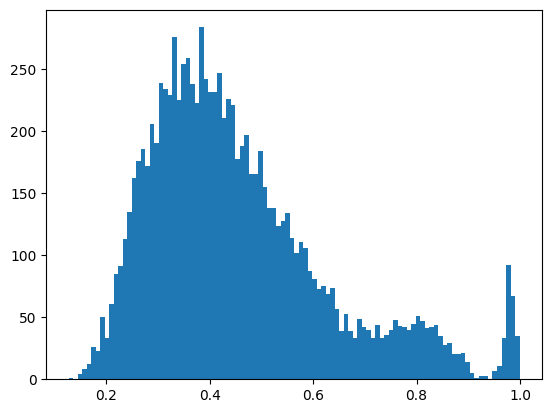

In [21]:
plt.hist(leverage_scores_full.cpu().numpy(), bins=100)

(array([ 15.,  32.,  97., 182., 270., 338., 382., 464., 497., 491., 464.,
        423., 389., 368., 318., 282., 257., 226., 203., 192., 158., 180.,
        155., 188., 138., 137., 158., 129., 133., 127., 120., 115., 106.,
         98.,  92., 100.,  89.,  81.,  97.,  86.,  77.,  62.,  66.,  58.,
         50.,  52.,  59.,  47.,  42.,  54.,  46.,  45.,  29.,  37.,  35.,
         25.,  28.,  26.,  28.,  25.,  26.,  26.,  28.,  29.,  28.,  25.,
         29.,  29.,  20.,  26.,  26.,  22.,  30.,  20.,  24.,  17.,  13.,
         11.,  20.,  14.,   5.,  12.,   9.,   5.,   3.,   2.,   2.,   2.,
          5.,   4.,   4.,   7.,   9.,  13.,  25.,  35.,  46.,  33.,  20.,
         28.]),
 array([0.05205643, 0.06152587, 0.07099532, 0.08046477, 0.08993421,
        0.09940366, 0.10887311, 0.11834255, 0.127812  , 0.13728145,
        0.14675088, 0.15622033, 0.16568978, 0.17515923, 0.18462867,
        0.19409811, 0.20356756, 0.21303701, 0.22250645, 0.2319759 ,
        0.24144535, 0.25091478, 0.26038423, 0.

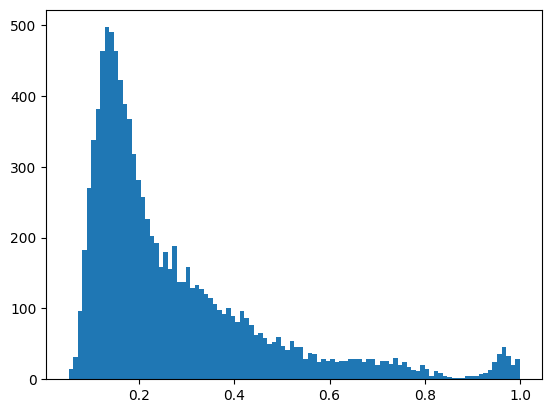

In [22]:
plt.hist(leverage_scores_rrls.cpu().numpy(), bins=100)

(array([  1.,   0.,   2.,   1.,   3.,   2.,   0.,  16.,  37.,  95., 143.,
        245., 304., 377., 404., 457., 495., 461., 461., 369., 381., 353.,
        324., 292., 287., 265., 224., 244., 228., 202., 204., 191., 188.,
        156., 159., 158., 128., 103., 134., 128., 124., 100.,  98., 105.,
         88.,  75.,  90.,  73.,  52.,  55.,  80.,  65.,  59.,  66.,  57.,
         56.,  40.,  39.,  34.,  55.,  33.,  25.,  29.,  31.,  31.,  22.,
         19.,  21.,  20.,  14.,  13.,  18.,  11.,  10.,   9.,  10.,  12.,
          7.,   6.,   3.,   8.,   6.,   1.,   0.,   1.,   1.,   1.,   1.,
          0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,
          1.]),
 array([1.85872558e-13, 9.45305265e-03, 1.89061053e-02, 2.83591561e-02,
        3.78122106e-02, 4.72652614e-02, 5.67183122e-02, 6.61713630e-02,
        7.56244212e-02, 8.50774720e-02, 9.45305228e-02, 1.03983574e-01,
        1.13436624e-01, 1.22889683e-01, 1.32342726e-01, 1.41795784e-01,
        1.51248842e-01, 1.6070

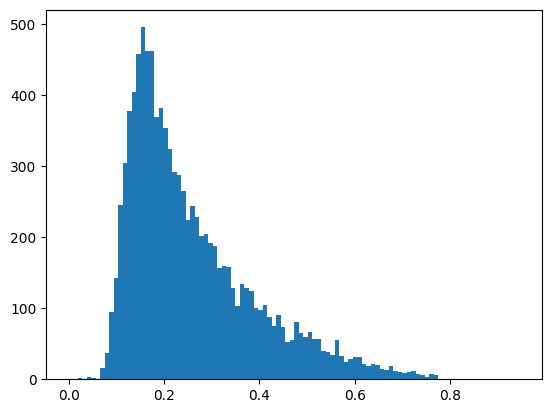

In [23]:
plt.hist(leverage_scores_rand.cpu().numpy(), bins=100)

In [24]:
eff_dim_full = eff_dim(K_full, lambd)
eff_dim_rrls = eff_dim(K_rrls, lambd)
eff_dim_rand = eff_dim(K_rand, lambd)

print(f"Effective dimension of full kernel matrix = {eff_dim_full}")
print(f"Effective dimension of RRLS approximation = {eff_dim_rrls}")
print(f"Effective dimension of random approximation = {eff_dim_rand}")

Effective dimension of full kernel matrix = 4261.5849609375
Effective dimension of RRLS approximation = 2451.679443359375
Effective dimension of random approximation = 2296.46728515625


In [25]:
print("Sum of leverage scores for full kernel matrix = ", torch.sum(leverage_scores_full))

Sum of leverage scores for full kernel matrix =  tensor(4566.6992, device='cuda:1')


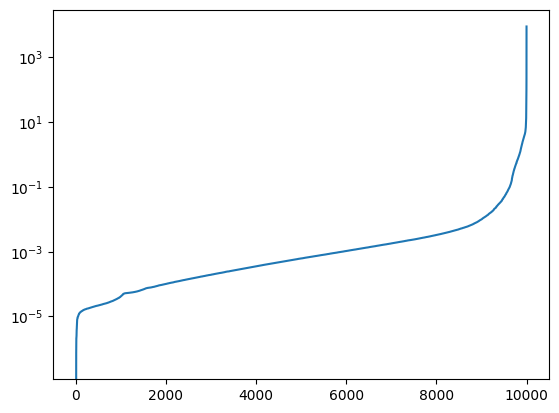

In [26]:
plt.semilogy(torch.linalg.eigvalsh(K_full).cpu().numpy())